##### Read Dataset and Create Loaders: 5%

In [10]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Hyper Parameters
num_epochs = 120 # 50 -> 100 -> 120
batch_size = 64 # 64 -> 128 -> 256

in_channels = 3
out_channels = 64

block_number = 8 # 6 -> 8 // 12 takes SO MUCH TIME
reduction_factor = 4 # 4 -> 2
k = 3 # 32 -> 6

image_size = 32 # this only matters if you're using something like MaxPool2D which changes size
learning_rate = 0.0001 # this is for the loss and optimizer

# Convertion of Images to Tensor
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # Add rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Add colour jitter
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Reading the DataSet
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Creating the Loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


##### Create the Model: 40%

In [11]:
# Stem part of the model - used to reduce
# the spatial dimensions by creating a convolutional layer
class Stem(nn.Module):
    def __init__(self):
        super(Stem, self).__init__()
        self.conv1 = nn.Conv2d(3, out_channels, 3, padding=1)
        # creating a more complex stem layer improves accuracy
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)        

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        return out

In [12]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, reduction_factor, k, image_size):
        super(Block, self).__init__()
        self.k = k
        self.image_size = image_size
        
        # Expert branch:
        # 1. Spatially average pool the feature map to 1x1 
        # 2. Flatten it to a vector of size [in_channels]
        # 3. Pass it through two FC layers with a ReLU in between;
        #    the first FC reduces the dimensions from in_channels to out_channels//reduction_factor.
        # 4. The second projects to k values.
        # 5. Finally, a softmax over the k elements produces the attention vector a.
        self.avgPool = nn.AvgPool2d(kernel_size=image_size, stride=image_size)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_channels, out_channels // reduction_factor)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(out_channels // reduction_factor, k)
        self.softmax = nn.Softmax(dim=1)
        
        # Main branch:
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            for _ in range(k)
        ])
        self.bns = nn.ModuleList([
            nn.BatchNorm2d(out_channels) for _ in range(k)
        ])
        self.dropout = nn.Dropout(p=0.3)
        self.post_relu = nn.ReLU()
        
    def expert_branch(self, x):
        # x: [batch, in_channels, H, W] where H == image_size, W == image_size ideally
        out = self.avgPool(x)            # Shape: [batch, in_channels, 1, 1]
        out = self.flatten(out)          # Shape: [batch, in_channels]
        out = self.fc1(out)          # Shape: [batch, out_channels//reduction_factor]
        out = self.relu(out)
        out = self.fc2(out)          # Shape: [batch, k]
        return self.softmax(out)         # Final attention vector: [batch, k]
    
    def forward(self, x):
        multipliers = self.expert_branch(x)  # Shape: [batch, k]
        
        conv_outputs = []
        for i in range(self.k):
            out = self.convs[i](x)           # [batch, out_channels, H, W]
            out = self.bns[i](out)
            out = self.post_relu(out)
            out = self.dropout(out)
            conv_outputs.append(out)
        # Stack conv outputs
        conv_outputs = torch.stack(conv_outputs, dim=1)
        
        # Expand multipliers from [batch, k] to [batch, k, 1, 1, 1]
        multipliers_expanded = multipliers.unsqueeze(2).unsqueeze(3).unsqueeze(4)
        # Multiply each conv branch output by its corresponding attention score.
        weighted = conv_outputs * multipliers_expanded
        out = weighted.sum(dim=1)
        return out


In [13]:
class BackBone(nn.Module):
    def __init__(self, num_blocks, in_channels, out_channels, reduction_factor, k_channels, image_size):
        super(BackBone, self).__init__()
        self.blocks = nn.ModuleList()
        for i in range(num_blocks):
            self.blocks.append(Block(in_channels, out_channels, reduction_factor, k_channels, image_size))

    def forward(self, x):
        out = x
        for i, block in enumerate(self.blocks):
            out = block(out)
        return out


In [14]:
class Classifier(nn.Module):
    def __init__(self, channels, image_size, num_outputs):
        super(Classifier, self).__init__()
        # Computing mean feature f
        # self.reduction_factor = 8
        
        self.avgPool = nn.AvgPool2d(reduction_factor)
        self.flatten = nn.Flatten()
        # Passing f to clasifier
        self.num_inputs = channels*((image_size // reduction_factor)**2)

        self.MLP = MLP(self.num_inputs, num_outputs, 1000, 500)


    def forward(self, x):
        out = self.avgPool(x)
        out = self.flatten(out)
        out = self.MLP(out)
        return out

class MLP(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hidden_1, num_hidden_2):
        super(MLP, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.linear1 = nn.Linear(num_inputs, num_hidden_1)
        self.linear2 = nn.Linear(num_hidden_1, num_hidden_2)
        self.linear3 = nn.Linear(num_hidden_2, num_outputs)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = x.view(-1, self.num_inputs)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = torch.relu(x)
        out = self.linear3(x)
        return out




In [15]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # CIFAR10 has 10 classes
    self.num_outputs = 10

    # CIFAR10 is 32x32
    # Using MaxPool will reduce it to 16x16
    self.image_size = image_size
    # Bringing all the model parts together
    self.stem = Stem()
    self.backbone = BackBone(block_number, out_channels, out_channels, reduction_factor, k, image_size)
    self.classifier = Classifier(out_channels, image_size, self.num_outputs)

  def forward(self, x):
    out = self.stem(x)
    out = self.backbone(out)
    out = self.classifier(out)
    return out

##### Create the loss and optimizer: 5%.

In [16]:
# Create the model
net = Net().to(device)

# Set the loss and optimiser
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0001) # , weight_decay=0.0005 -> 0.0001

##### Write the training script to train the model. Provide in the report: 30%

In [17]:
# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return 100 * correct / total

# Tracking for plotting
train_losses = []
test_accuracies = []
train_accuracies = []

# Training loop
def train(net, train_loader, test_loader, loss_fn, num_epochs, optimizer):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        train_acc = calculate_accuracy(train_loader, net)
        test_acc = calculate_accuracy(test_loader, net)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)


        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

    # Plotting training curves
    epochs = np.arange(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Acc')
    plt.plot(epochs, test_accuracies, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()

Epoch [1/120], Loss: 1.7630, Train Acc: 37.38%, Test Acc: 43.87%
Epoch [2/120], Loss: 1.4115, Train Acc: 49.16%, Test Acc: 55.55%
Epoch [3/120], Loss: 1.2535, Train Acc: 54.83%, Test Acc: 60.48%
Epoch [4/120], Loss: 1.1377, Train Acc: 58.71%, Test Acc: 64.62%
Epoch [5/120], Loss: 1.0434, Train Acc: 62.86%, Test Acc: 68.87%
Epoch [6/120], Loss: 0.9834, Train Acc: 64.09%, Test Acc: 68.31%
Epoch [7/120], Loss: 0.9322, Train Acc: 68.18%, Test Acc: 71.28%
Epoch [8/120], Loss: 0.8837, Train Acc: 66.68%, Test Acc: 70.76%
Epoch [9/120], Loss: 0.8496, Train Acc: 67.43%, Test Acc: 73.17%
Epoch [10/120], Loss: 0.8216, Train Acc: 70.42%, Test Acc: 74.10%
Epoch [11/120], Loss: 0.7909, Train Acc: 74.78%, Test Acc: 77.44%
Epoch [12/120], Loss: 0.7669, Train Acc: 74.98%, Test Acc: 76.97%
Epoch [13/120], Loss: 0.7430, Train Acc: 75.84%, Test Acc: 77.91%
Epoch [14/120], Loss: 0.7252, Train Acc: 76.02%, Test Acc: 78.11%
Epoch [15/120], Loss: 0.6981, Train Acc: 76.29%, Test Acc: 78.42%
Epoch [16/120], Los

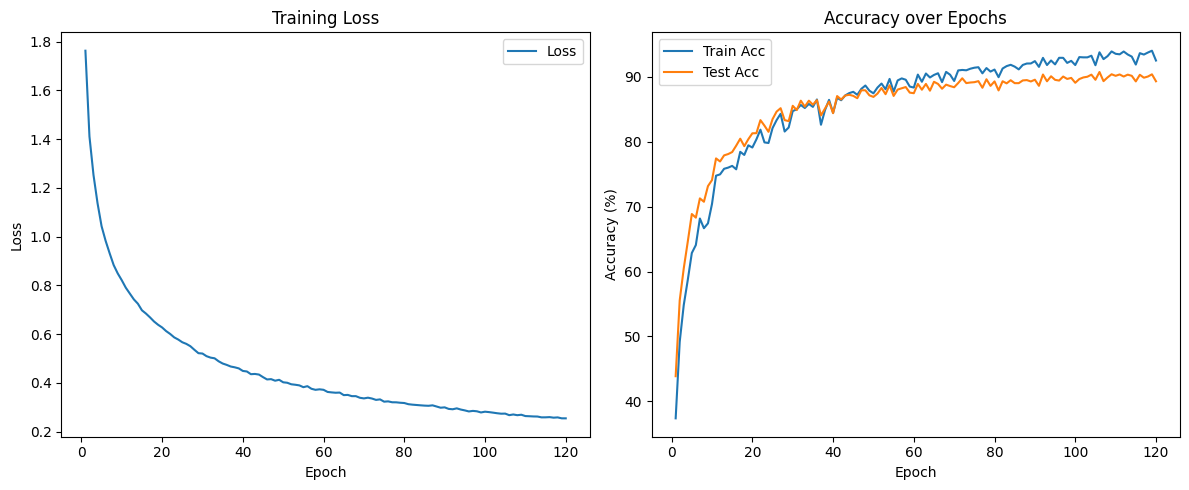

In [18]:
#execute training method
train(net, train_loader, test_loader, loss_fn, num_epochs, optimizer)